**Install requirements**

In [0]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'
#!pip install 'livelossplot'

**Import libraries**

In [0]:
# Torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet


# Tools
import random
import os
import logging
from PIL import Image
#from tqdm import tqdm
from tqdm.notebook import tqdm
import numpy as np
from sklearn.model_selection import train_test_split


# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#from livelossplot import PlotLosses


# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/RoboTuan/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

from Caltech101.caltech_dataset import Caltech
DATA_DIR = 'Caltech101/101_ObjectCategories'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Cloning into 'Homework2-Caltech101'...
remote: Enumerating objects: 9291, done.
remote: Total 9291 (delta 0), reused 0 (delta 0), pack-reused 9291
Receiving objects: 100% (9291/9291), 129.49 MiB | 10.68 MiB/s, done.
Resolving deltas: 100% (22/22), done.
Checking out files: 100% (9152/9152), done.


**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

#updated from 102 to 101, ask if it's correct
NUM_CLASSES = 101 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
#1e-3
#1e-2
#1e-1
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 40      # Total number of training epochs (iterations over dataset)
#30
#40
STEP_SIZE = 30       # How many epochs before decreasing learning rate (if using a step-down policy)
#10
#20
#30
GAMMA = 0.1          # Multiplicative factor for learning rate step-down
#1
#0.1
#0.01

LOG_FREQUENCY = 10

**Utility Functions**



In [0]:
def plot_accuracy_loss(train_acc, val_acc, train_loss, val_loss, title=None):
  figure, axes = plt.subplots(1, 2, figsize=(10, 5)) 

  axes[0].plot(range(1, NUM_EPOCHS+1), train_loss, label="Train")
  axes[0].plot(range(1, NUM_EPOCHS+1), val_loss, label="Validation")
  axes[0].set_title("Loss")
  axes[0].legend()

  axes[1].plot(range(1, NUM_EPOCHS+1), train_acc,  label="Train")
  axes[1].plot(range(1, NUM_EPOCHS+1), val_acc,  label="Validation")
  axes[1].set_title("Accuracy")
  axes[1].legend()

  if title != None:
    figure.savefig(title + ".png")

  plt.show()

In [0]:
def loadCaltech101(train_transform, eval_transform):
  # Prepare Pytorch train/test Datasets
  train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
  test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)


  train_len = int(train_dataset.__len__() * 0.5)
  val_len = int(train_dataset.__len__() * 0.5)

  train_indexes = np.arange(train_dataset.__len__())
  train_labels = np.empty(train_dataset.__len__(), dtype=int)
  for index in train_indexes:
    train_labels[index] = train_dataset.__getitem__(index)[1]


  train_indexes, val_indexes, _, _ = train_test_split(train_indexes, train_labels, test_size=0.5, random_state=42, stratify=train_labels)


  # #train_indexes, val_indexes = torch.utils.data.random_split(train_dataset, [train_len, val_len])

  #train_indexes, val_indexes = torch.utils.data.random_split(list(i for i in range(train_dataset.__len__())),[train_len, val_len])

  # #train_indexes = # split the indices for your train split
  # #val_indexes = # split the indices for your val split

  val_dataset = Subset(train_dataset, val_indexes)
  train_dataset = Subset(train_dataset, train_indexes)

  # Check dataset sizes
  print('Train Dataset: {}'.format(len(train_dataset)))
  print('Valid Dataset: {}'.format(len(val_dataset)))
  print('Train + Valid dataset: {}'.format(len(train_dataset) + len(val_dataset)))
  print('Test Dataset: {}'.format(len(test_dataset)))

  return train_dataset, train_indexes, val_dataset, val_indexes, test_dataset


**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

**Prepare Dataset**

In [0]:
train_dataset, train_indexes, val_dataset, val_indexes, test_dataset = loadCaltech101(train_transform, eval_transform)

Train Dataset: 2892
Valid Dataset: 2892
Train + Valid dataset: 5784
Test Dataset: 2893


In [0]:
train_classes = np.zeros(101)

for elem in train_dataset:
  train_classes[elem[1]] += 1

val_classes = np.zeros(101)

for elem in val_dataset:
  val_classes[elem[1]] += 1

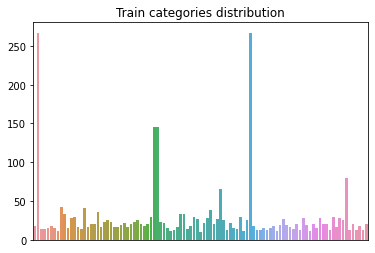

In [0]:
#print(train_classes)
#current_palette = sns.color_palette("colorblind")
ax = sns.barplot(x=np.linspace(0, 100, num=101), y=train_classes)
ax.set_xticks([])
ax.set_title("Train categories distribution")
plt.savefig("train_cat.png")
plt.show()

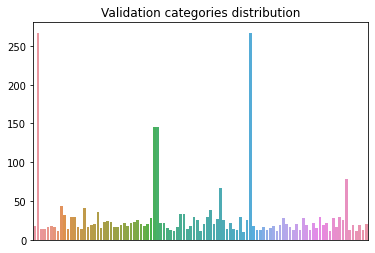

In [0]:
#print(val_classes)
ax = sns.barplot(x=np.linspace(0, 100, num=101), y=val_classes)
ax.set_xticks([])
ax.set_title("Validation categories distribution")
plt.savefig("val_cat.png")
plt.show()

**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
# These last 2 don't need drop last and shuffling, because are only used for evaluation
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [0]:
net = alexnet() # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Validation**

In [0]:
def validation(network):
  #net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  network.train(False) # Set Network to evaluation mode

  running_corrects = 0
  with torch.no_grad(): ## AGGIUNTO PER EVITARE CUDA OUT OF MEMORY ERROR, VEDERE SE VA BENE
    for images, labels in tqdm(val_dataloader):
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # Forward Pass
      outputs = network(images)

      # Get predictions
      _, preds = torch.max(outputs.data, 1)

      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()

      # Compute loss based on output and ground truth
      loss = criterion(outputs, labels)

  # Calculate Accuracy
  accuracy = running_corrects / float(len(val_dataset))

  print('Validation Accuracy: {}'.format(accuracy))
  print()
  return accuracy, loss

**Train**

In [0]:
def train(network):
  # By default, everything is loaded to cpu
  network = network.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

  cudnn.benchmark # Calling this optimizes runtime

  current_step = 0

  train_loss = []
  train_accuracy = []
  val_loss = []
  val_accuracy = []

  # Start iterating over the epochs
  # Check if it is correct get_last_lr() or get_lr() (this generates a warning)
  for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

    running_corrects = 0.0
    running_loss = 0.0

    # Iterate over the dataset
    for images, labels in train_dataloader:
      # Bring data over the device of choice
      #print(labels)
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      network.train() # Sets module in training mode

      # PyTorch, by default, accumulates gradients after each backward pass
      # We need to manually set the gradients to zero before starting a new iteration
      optimizer.zero_grad() # Zero-ing the gradients

      # Forward pass to the network
      outputs = network(images)

      # Compute loss based on output and ground truth
      loss = criterion(outputs, labels)

      # Log loss
      if current_step % LOG_FREQUENCY == 0:
        print('Step {}, Loss {}'.format(current_step, loss.item()))

      # Compute gradients for each layer and update weights
      loss.backward()  # backward pass: computes gradients
      optimizer.step() # update weights based on accumulated gradients

      # Get predictions
      _, preds = torch.max(outputs.data, 1)

      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()
      running_loss += loss.item() * images.size(0)
      
      current_step += 1

    train_loss.append(running_loss / float(len(train_dataset)))
    train_accuracy.append(running_corrects / float(len(train_dataset)))

    val_acc_loss = validation(network)
    print(val_acc_loss)
    val_accuracy.append(val_acc_loss[0])
    val_loss.append(val_acc_loss[1])

    # Step the scheduler
    scheduler.step() 

  return  train_loss, val_loss, train_accuracy, val_accuracy


In [0]:
train_loss, val_loss, train_accuracy, val_accuracy = train(net)

Starting epoch 1/40, LR = [0.01]
Step 0, Loss 4.6153740882873535
Step 10, Loss 4.603692531585693



Validation Accuracy: 0.09232365145228216

(0.09232365145228216, tensor(4.6002, device='cuda:0'))
Starting epoch 2/40, LR = [0.01]
Step 20, Loss 4.579482078552246



Validation Accuracy: 0.09232365145228216

(0.09232365145228216, tensor(4.5705, device='cuda:0'))
Starting epoch 3/40, LR = [0.01]
Step 30, Loss 4.550523281097412



Validation Accuracy: 0.16009681881051174

(0.16009681881051174, tensor(4.5250, device='cuda:0'))
Starting epoch 4/40, LR = [0.01]
Step 40, Loss 4.446761608123779



Validation Accuracy: 0.09197786998616875

(0.09197786998616875, tensor(4.1734, device='cuda:0'))
Starting epoch 5/40, LR = [0.01]
Step 50, Loss 4.2881622314453125



Validation Accuracy: 0.09232365145228216

(0.09232365145228216, tensor(4.1240, device='cuda:0'))
Starting epoch 6/40, LR = [0.01]
Step 60, Loss 4.31633186340332



Validation Accuracy: 0.09197786998616875

(0.09197786998616875, tensor(4.0809, device='cuda:0'))
Starting epoch 7/40, LR = [0.01]
Step 70, Loss 4.1900835037231445



Validation Accuracy: 0.09647302904564316

(0.09647302904564316, tensor(4.0403, device='cuda:0'))
Starting epoch 8/40, LR = [0.01]
Step 80, Loss 4.162636756896973



Validation Accuracy: 0.15318118948824344

(0.15318118948824344, tensor(4.0495, device='cuda:0'))
Starting epoch 9/40, LR = [0.01]
Step 90, Loss 3.985091209411621



Validation Accuracy: 0.15525587828492393

(0.15525587828492393, tensor(3.9626, device='cuda:0'))
Starting epoch 10/40, LR = [0.01]
Step 100, Loss 4.174790859222412



Validation Accuracy: 0.19847856154910096

(0.19847856154910096, tensor(3.9379, device='cuda:0'))
Starting epoch 11/40, LR = [0.01]
Step 110, Loss 4.012746334075928
Step 120, Loss 3.9507200717926025



Validation Accuracy: 0.20055325034578148

(0.20055325034578148, tensor(3.8024, device='cuda:0'))
Starting epoch 12/40, LR = [0.01]
Step 130, Loss 3.838768482208252



Validation Accuracy: 0.21161825726141079

(0.21161825726141079, tensor(3.6222, device='cuda:0'))
Starting epoch 13/40, LR = [0.01]
Step 140, Loss 3.9019923210144043



Validation Accuracy: 0.21161825726141079

(0.21161825726141079, tensor(3.4567, device='cuda:0'))
Starting epoch 14/40, LR = [0.01]
Step 150, Loss 3.7342147827148438



Validation Accuracy: 0.22786998616874135

(0.22786998616874135, tensor(3.4278, device='cuda:0'))
Starting epoch 15/40, LR = [0.01]
Step 160, Loss 3.501824378967285



Validation Accuracy: 0.24031811894882435

(0.24031811894882435, tensor(3.2876, device='cuda:0'))
Starting epoch 16/40, LR = [0.01]
Step 170, Loss 3.4201719760894775



Validation Accuracy: 0.21784232365145229

(0.21784232365145229, tensor(3.7749, device='cuda:0'))
Starting epoch 17/40, LR = [0.01]
Step 180, Loss 3.5229921340942383



Validation Accuracy: 0.26175656984785617

(0.26175656984785617, tensor(3.2132, device='cuda:0'))
Starting epoch 18/40, LR = [0.01]
Step 190, Loss 3.3868677616119385



Validation Accuracy: 0.26175656984785617

(0.26175656984785617, tensor(3.1547, device='cuda:0'))
Starting epoch 19/40, LR = [0.01]
Step 200, Loss 3.190232276916504



Validation Accuracy: 0.2579529737206086

(0.2579529737206086, tensor(3.2619, device='cuda:0'))
Starting epoch 20/40, LR = [0.01]
Step 210, Loss 3.2596757411956787



Validation Accuracy: 0.2818118948824343

(0.2818118948824343, tensor(3.2173, device='cuda:0'))
Starting epoch 21/40, LR = [0.01]
Step 220, Loss 3.4247231483459473
Step 230, Loss 3.2724609375



Validation Accuracy: 0.2859612724757953

(0.2859612724757953, tensor(3.1485, device='cuda:0'))
Starting epoch 22/40, LR = [0.01]
Step 240, Loss 3.0178542137145996



Validation Accuracy: 0.2752420470262794

(0.2752420470262794, tensor(3.1426, device='cuda:0'))
Starting epoch 23/40, LR = [0.01]
Step 250, Loss 3.1812081336975098



Validation Accuracy: 0.3070539419087137

(0.3070539419087137, tensor(2.9458, device='cuda:0'))
Starting epoch 24/40, LR = [0.01]
Step 260, Loss 2.9767558574676514



Validation Accuracy: 0.31466113416320884

(0.31466113416320884, tensor(2.8810, device='cuda:0'))
Starting epoch 25/40, LR = [0.01]
Step 270, Loss 2.985844612121582



Validation Accuracy: 0.3236514522821577

(0.3236514522821577, tensor(2.8743, device='cuda:0'))
Starting epoch 26/40, LR = [0.01]
Step 280, Loss 2.786752939224243



Validation Accuracy: 0.3312586445366528

(0.3312586445366528, tensor(2.7436, device='cuda:0'))
Starting epoch 27/40, LR = [0.01]
Step 290, Loss 2.6885340213775635



Validation Accuracy: 0.35235131396957126

(0.35235131396957126, tensor(2.7321, device='cuda:0'))
Starting epoch 28/40, LR = [0.01]
Step 300, Loss 2.8932688236236572



Validation Accuracy: 0.3789764868603043

(0.3789764868603043, tensor(2.6103, device='cuda:0'))
Starting epoch 29/40, LR = [0.01]
Step 310, Loss 2.326124906539917



Validation Accuracy: 0.3454356846473029

(0.3454356846473029, tensor(2.7764, device='cuda:0'))
Starting epoch 30/40, LR = [0.01]
Step 320, Loss 2.507455825805664



Validation Accuracy: 0.39315352697095435

(0.39315352697095435, tensor(2.4370, device='cuda:0'))
Starting epoch 31/40, LR = [0.001]
Step 330, Loss 2.203775405883789
Step 340, Loss 2.031407594680786



Validation Accuracy: 0.4024896265560166

(0.4024896265560166, tensor(2.3992, device='cuda:0'))
Starting epoch 32/40, LR = [0.001]
Step 350, Loss 2.0709450244903564



Validation Accuracy: 0.4135546334716459

(0.4135546334716459, tensor(2.3923, device='cuda:0'))
Starting epoch 33/40, LR = [0.001]
Step 360, Loss 2.041537284851074



Validation Accuracy: 0.42289073305670816

(0.42289073305670816, tensor(2.3475, device='cuda:0'))
Starting epoch 34/40, LR = [0.001]
Step 370, Loss 2.0073022842407227



Validation Accuracy: 0.4263485477178423

(0.4263485477178423, tensor(2.3278, device='cuda:0'))
Starting epoch 35/40, LR = [0.001]
Step 380, Loss 2.084606885910034



Validation Accuracy: 0.4242738589211618

(0.4242738589211618, tensor(2.3359, device='cuda:0'))
Starting epoch 36/40, LR = [0.001]
Step 390, Loss 1.9725685119628906



Validation Accuracy: 0.4287690179806362

(0.4287690179806362, tensor(2.3256, device='cuda:0'))
Starting epoch 37/40, LR = [0.001]
Step 400, Loss 1.8956362009048462



Validation Accuracy: 0.4322268326417704

(0.4322268326417704, tensor(2.3243, device='cuda:0'))
Starting epoch 38/40, LR = [0.001]
Step 410, Loss 1.917129397392273



Validation Accuracy: 0.43326417704011067

(0.43326417704011067, tensor(2.3121, device='cuda:0'))
Starting epoch 39/40, LR = [0.001]
Step 420, Loss 1.812828540802002



Validation Accuracy: 0.4363762102351314

(0.4363762102351314, tensor(2.3264, device='cuda:0'))
Starting epoch 40/40, LR = [0.001]
Step 430, Loss 1.870407223701477



Validation Accuracy: 0.4387966804979253

(0.4387966804979253, tensor(2.3101, device='cuda:0'))


**Test**

In [0]:
 def testing(network):
  network = network.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  network.train(False) # Set Network to evaluation mode

  running_corrects = 0
  for images, labels in tqdm(test_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = network(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  accuracy = running_corrects / float(len(test_dataset))

  print('Test Accuracy: {}'.format(accuracy))

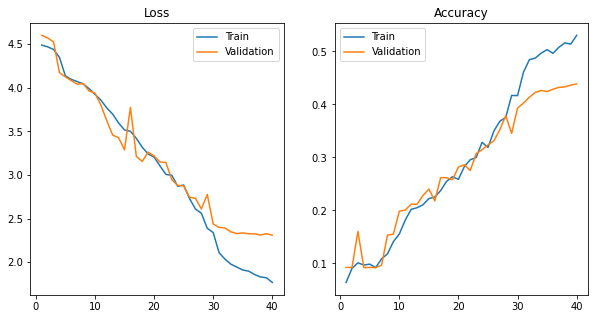


Test Accuracy: 0.44210162461113034


In [0]:
#validation(net)
#len(val_dataloader)
plot_accuracy_loss(train_accuracy, val_accuracy, train_loss, val_loss)
testing(net)

**Transfer Learning** 

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101 

BATCH_SIZE = 512 #If I change this, I need to reload the Dataloaders!!!
#256

LR = 1e-2 

MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-2  

NUM_EPOCHS = 15
#30
#20
#15      
STEP_SIZE = 10
#20
#10
#5      
GAMMA = 0.1         

LOG_FREQUENCY = 10

**Preprocessing for transfer learning** 

In [0]:
# Normalization for Imagenet dataset
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      normalize # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      normalize                                    
])

In [0]:
# Get datasets and indeces
train_dataset, train_indexes, val_dataset, val_indexes, test_dataset = loadCaltech101(train_transform, eval_transform)


# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
# These last 2 don't need drop last and shuffling, because are only used for evaluation
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


Train Dataset: 2892
Valid Dataset: 2892
Train + Valid dataset: 5784
Test Dataset: 2893


**Train the whole pre-trained network**

In [0]:
# Load the pre-trained network
pre_net = alexnet(pretrained=True)

# Add FC layer for classification
pre_net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = pre_net.classifier[6].parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [0]:
train_loss, val_loss, train_accuracy, val_accuracy = train(pre_net)

Starting epoch 1/15, LR = [0.01]
Step 0, Loss 4.793471336364746



Validation Accuracy: 0.49239280774550487

(0.49239280774550487, tensor(2.2171, device='cuda:0'))
Starting epoch 2/15, LR = [0.01]



Validation Accuracy: 0.6849930843706777

(0.6849930843706777, tensor(1.3203, device='cuda:0'))
Starting epoch 3/15, LR = [0.01]
Step 10, Loss 1.1336396932601929



Validation Accuracy: 0.7558782849239281

(0.7558782849239281, tensor(0.9879, device='cuda:0'))
Starting epoch 4/15, LR = [0.01]



Validation Accuracy: 0.7973720608575381

(0.7973720608575381, tensor(0.8319, device='cuda:0'))
Starting epoch 5/15, LR = [0.01]
Step 20, Loss 0.3749058246612549



Validation Accuracy: 0.8091286307053942

(0.8091286307053942, tensor(0.7670, device='cuda:0'))
Starting epoch 6/15, LR = [0.01]



Validation Accuracy: 0.8160442600276625

(0.8160442600276625, tensor(0.7171, device='cuda:0'))
Starting epoch 7/15, LR = [0.01]
Step 30, Loss 0.304533988237381



Validation Accuracy: 0.8205394190871369

(0.8205394190871369, tensor(0.6945, device='cuda:0'))
Starting epoch 8/15, LR = [0.01]



Validation Accuracy: 0.8215767634854771

(0.8215767634854771, tensor(0.6785, device='cuda:0'))
Starting epoch 9/15, LR = [0.01]
Step 40, Loss 0.17683224380016327



Validation Accuracy: 0.8188105117565698

(0.8188105117565698, tensor(0.6714, device='cuda:0'))
Starting epoch 10/15, LR = [0.01]



Validation Accuracy: 0.8233056708160442

(0.8233056708160442, tensor(0.6628, device='cuda:0'))
Starting epoch 11/15, LR = [0.001]
Step 50, Loss 0.148135706782341



Validation Accuracy: 0.822268326417704

(0.822268326417704, tensor(0.6629, device='cuda:0'))
Starting epoch 12/15, LR = [0.001]



Validation Accuracy: 0.8233056708160442

(0.8233056708160442, tensor(0.6629, device='cuda:0'))
Starting epoch 13/15, LR = [0.001]
Step 60, Loss 0.14933747053146362



Validation Accuracy: 0.8233056708160442

(0.8233056708160442, tensor(0.6628, device='cuda:0'))
Starting epoch 14/15, LR = [0.001]



Validation Accuracy: 0.8226141078838174

(0.8226141078838174, tensor(0.6638, device='cuda:0'))
Starting epoch 15/15, LR = [0.001]
Step 70, Loss 0.15085884928703308



Validation Accuracy: 0.8233056708160442

(0.8233056708160442, tensor(0.6634, device='cuda:0'))


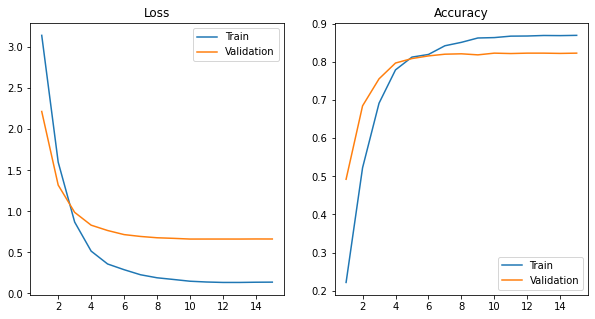


Test Accuracy: 0.8333909436571033


In [0]:
plot_accuracy_loss(train_accuracy, val_accuracy, train_loss, val_loss, title="trained_ep15_lr1e-2_steps10_batch512_wd5e-2")
testing(pre_net)

**Train only the fully connected layers**

In [0]:
# Load the pre-trained network
pre_net = alexnet(pretrained=True)

# Freeze convolutional layers
for param in pre_net.features.parameters():
    param.requires_grad = False

# Add FC layer for classification
pre_net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = pre_net.classifier[6].parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [0]:
train_loss, val_loss, train_accuracy, val_accuracy = train(pre_net)

Starting epoch 1/15, LR = [0.01]
Step 0, Loss 4.869210720062256



Validation Accuracy: 0.4899723374827109

(0.4899723374827109, tensor(2.2208, device='cuda:0'))
Starting epoch 2/15, LR = [0.01]



Validation Accuracy: 0.6773858921161826

(0.6773858921161826, tensor(1.3558, device='cuda:0'))
Starting epoch 3/15, LR = [0.01]
Step 10, Loss 1.0900908708572388



Validation Accuracy: 0.758298755186722

(0.758298755186722, tensor(1.0148, device='cuda:0'))
Starting epoch 4/15, LR = [0.01]



Validation Accuracy: 0.7935684647302904

(0.7935684647302904, tensor(0.8600, device='cuda:0'))
Starting epoch 5/15, LR = [0.01]
Step 20, Loss 0.5062127709388733



Validation Accuracy: 0.8084370677731674

(0.8084370677731674, tensor(0.7797, device='cuda:0'))
Starting epoch 6/15, LR = [0.01]



Validation Accuracy: 0.809820193637621

(0.809820193637621, tensor(0.7382, device='cuda:0'))
Starting epoch 7/15, LR = [0.01]
Step 30, Loss 0.2621740698814392



Validation Accuracy: 0.8163900414937759

(0.8163900414937759, tensor(0.7120, device='cuda:0'))
Starting epoch 8/15, LR = [0.01]



Validation Accuracy: 0.8150069156293223

(0.8150069156293223, tensor(0.7052, device='cuda:0'))
Starting epoch 9/15, LR = [0.01]
Step 40, Loss 0.2053772509098053



Validation Accuracy: 0.8215767634854771

(0.8215767634854771, tensor(0.6940, device='cuda:0'))
Starting epoch 10/15, LR = [0.01]



Validation Accuracy: 0.822268326417704

(0.822268326417704, tensor(0.6813, device='cuda:0'))
Starting epoch 11/15, LR = [0.001]
Step 50, Loss 0.16933485865592957



Validation Accuracy: 0.8253803596127247

(0.8253803596127247, tensor(0.6763, device='cuda:0'))
Starting epoch 12/15, LR = [0.001]



Validation Accuracy: 0.8267634854771784

(0.8267634854771784, tensor(0.6746, device='cuda:0'))
Starting epoch 13/15, LR = [0.001]
Step 60, Loss 0.1512627899646759



Validation Accuracy: 0.826417704011065

(0.826417704011065, tensor(0.6733, device='cuda:0'))
Starting epoch 14/15, LR = [0.001]



Validation Accuracy: 0.8267634854771784

(0.8267634854771784, tensor(0.6728, device='cuda:0'))
Starting epoch 15/15, LR = [0.001]
Step 70, Loss 0.14787209033966064



Validation Accuracy: 0.826417704011065

(0.826417704011065, tensor(0.6725, device='cuda:0'))


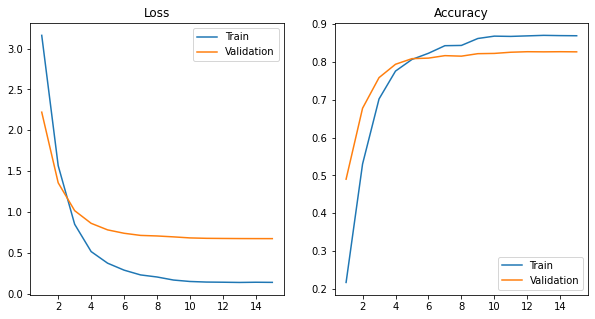


Test Accuracy: 0.8361562391980643


In [0]:
plot_accuracy_loss(train_accuracy, val_accuracy, train_loss, val_loss, title="trained_only_FC_layers")
testing(pre_net)

**Train only the convolutional layers**

In [0]:
# Load the pre-trained network
pre_net = alexnet(pretrained=True)

# Freeze fully connected layers
for param in pre_net.classifier.parameters():
  param.requires_grad = False

# Add FC layer for classification
pre_net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = pre_net.classifier[6].parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)


In [0]:
train_loss, val_loss, train_accuracy, val_accuracy = train(pre_net)

Starting epoch 1/15, LR = [0.01]
Step 0, Loss 4.801321029663086



Validation Accuracy: 0.49688796680497926

(0.49688796680497926, tensor(2.2301, device='cuda:0'))
Starting epoch 2/15, LR = [0.01]



Validation Accuracy: 0.6742738589211619

(0.6742738589211619, tensor(1.3395, device='cuda:0'))
Starting epoch 3/15, LR = [0.01]
Step 10, Loss 1.1762014627456665



Validation Accuracy: 0.7614107883817427

(0.7614107883817427, tensor(0.9805, device='cuda:0'))
Starting epoch 4/15, LR = [0.01]



Validation Accuracy: 0.7949515905947441

(0.7949515905947441, tensor(0.8217, device='cuda:0'))
Starting epoch 5/15, LR = [0.01]
Step 20, Loss 0.4924769103527069



Validation Accuracy: 0.8094744121715076

(0.8094744121715076, tensor(0.7464, device='cuda:0'))
Starting epoch 6/15, LR = [0.01]



Validation Accuracy: 0.8163900414937759

(0.8163900414937759, tensor(0.6998, device='cuda:0'))
Starting epoch 7/15, LR = [0.01]
Step 30, Loss 0.28795453906059265



Validation Accuracy: 0.8205394190871369

(0.8205394190871369, tensor(0.6824, device='cuda:0'))
Starting epoch 8/15, LR = [0.01]



Validation Accuracy: 0.8229598893499308

(0.8229598893499308, tensor(0.6723, device='cuda:0'))
Starting epoch 9/15, LR = [0.01]
Step 40, Loss 0.1786230206489563



Validation Accuracy: 0.823997233748271

(0.823997233748271, tensor(0.6682, device='cuda:0'))
Starting epoch 10/15, LR = [0.01]



Validation Accuracy: 0.8246887966804979

(0.8246887966804979, tensor(0.6618, device='cuda:0'))
Starting epoch 11/15, LR = [0.001]
Step 50, Loss 0.1655462235212326



Validation Accuracy: 0.8233056708160442

(0.8233056708160442, tensor(0.6595, device='cuda:0'))
Starting epoch 12/15, LR = [0.001]



Validation Accuracy: 0.8278008298755186

(0.8278008298755186, tensor(0.6569, device='cuda:0'))
Starting epoch 13/15, LR = [0.001]
Step 60, Loss 0.14495308697223663



Validation Accuracy: 0.8284923928077456

(0.8284923928077456, tensor(0.6557, device='cuda:0'))
Starting epoch 14/15, LR = [0.001]



Validation Accuracy: 0.8281466113416321

(0.8281466113416321, tensor(0.6566, device='cuda:0'))
Starting epoch 15/15, LR = [0.001]
Step 70, Loss 0.15523943305015564



Validation Accuracy: 0.8284923928077456

(0.8284923928077456, tensor(0.6564, device='cuda:0'))


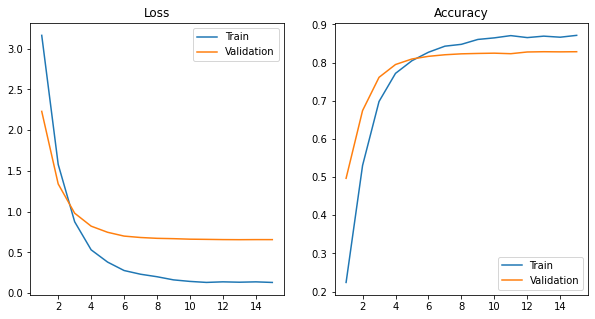


Test Accuracy: 0.8330452817144832


In [0]:
plot_accuracy_loss(train_accuracy, val_accuracy, train_loss, val_loss, title="trained_only_Conv_layers")
testing(pre_net)

**Data Augmentation**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101 

BATCH_SIZE = 512 #If I change this, I need to reload the Dataloaders!!!

LR = 1e-2 

MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-2  

NUM_EPOCHS = 15      
STEP_SIZE = 10
#10
#5      
GAMMA = 0.1         

LOG_FREQUENCY = 10

**Preprocessing for Data Augmentation**

In [0]:
# Normalization for Imagenet dataset
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.RandomCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomVerticalFlip(p=0.1),
                                      #transforms.RandomRotation(degrees=45),
                                      transforms.ColorJitter(brightness=0.5, contrast=0.4, saturation=0.3, hue=0.1),
                                      #transforms.RandomGrayscale(1),
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      normalize # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase 
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      normalize                                    
])

In [0]:
# Get datasets and indeces
train_dataset, train_indexes, val_dataset, val_indexes, test_dataset = loadCaltech101(train_transform, eval_transform)


# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
# These last 2 don't need drop last and shuffling, because are only used for evaluation
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


Train Dataset: 2892
Valid Dataset: 2892
Train + Valid dataset: 5784
Test Dataset: 2893


In [0]:
# Load the pre-trained network
pre_net = alexnet(pretrained=True)

# Freeze layers
for param in pre_net.parameters():
    param.requires_grad = False

# Add FC layer for classification
pre_net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
#pre_net.eval()

criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = pre_net.classifier[6].parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [0]:
train_loss, val_loss, train_accuracy, val_accuracy = train(pre_net)

Starting epoch 1/15, LR = [0.01]
Step 0, Loss 4.790119171142578



Validation Accuracy: 0.3914246196403873

(0.3914246196403873, tensor(2.5789, device='cuda:0'))
Starting epoch 2/15, LR = [0.01]



Validation Accuracy: 0.6006224066390041

(0.6006224066390041, tensor(1.7093, device='cuda:0'))
Starting epoch 3/15, LR = [0.01]
Step 10, Loss 1.7254693508148193



Validation Accuracy: 0.669432918395574

(0.669432918395574, tensor(1.3087, device='cuda:0'))
Starting epoch 4/15, LR = [0.01]



Validation Accuracy: 0.7171507607192255

(0.7171507607192255, tensor(1.0626, device='cuda:0'))
Starting epoch 5/15, LR = [0.01]
Step 20, Loss 0.9184025526046753



Validation Accuracy: 0.7354771784232366

(0.7354771784232366, tensor(1.0418, device='cuda:0'))
Starting epoch 6/15, LR = [0.01]



Validation Accuracy: 0.7392807745504841

(0.7392807745504841, tensor(0.9706, device='cuda:0'))
Starting epoch 7/15, LR = [0.01]
Step 30, Loss 0.592251718044281



Validation Accuracy: 0.7648686030428768

(0.7648686030428768, tensor(0.9621, device='cuda:0'))
Starting epoch 8/15, LR = [0.01]



Validation Accuracy: 0.7693637621023514

(0.7693637621023514, tensor(0.8374, device='cuda:0'))
Starting epoch 9/15, LR = [0.01]
Step 40, Loss 0.5536344647407532



Validation Accuracy: 0.7638312586445366

(0.7638312586445366, tensor(0.8976, device='cuda:0'))
Starting epoch 10/15, LR = [0.01]



Validation Accuracy: 0.7735131396957123

(0.7735131396957123, tensor(0.8876, device='cuda:0'))
Starting epoch 11/15, LR = [0.001]
Step 50, Loss 0.46204549074172974



Validation Accuracy: 0.7755878284923928

(0.7755878284923928, tensor(0.8769, device='cuda:0'))
Starting epoch 12/15, LR = [0.001]



Validation Accuracy: 0.7697095435684648

(0.7697095435684648, tensor(0.8142, device='cuda:0'))
Starting epoch 13/15, LR = [0.001]
Step 60, Loss 0.4249916076660156



Validation Accuracy: 0.7755878284923928

(0.7755878284923928, tensor(0.8234, device='cuda:0'))
Starting epoch 14/15, LR = [0.001]



Validation Accuracy: 0.7745504840940526

(0.7745504840940526, tensor(0.8920, device='cuda:0'))
Starting epoch 15/15, LR = [0.001]
Step 70, Loss 0.437645822763443



Validation Accuracy: 0.7780082987551867

(0.7780082987551867, tensor(0.7942, device='cuda:0'))


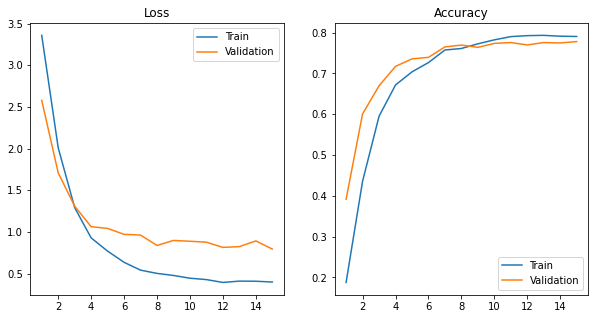


Test Accuracy: 0.8285516764604217


In [0]:
loss(train_accuracy, val_accuracy, train_loss, val_loss, title="hor_vert_jit_hue<sat")
testing(pre_net)